In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive"

 911_Class			        Classroom
'Barabasi 0 Preface.pdf'	       'Colab Notebooks'
'Barabasi 10 Spreading Phenomena.pdf'  'Esp.Pensa.Cerr_es_1° sem.gsheet'
'Barabasi 1 Introduction.pdf'	        ex0.pdf
'Barabasi 2 Graph Theory.pdf'	       'Fontana_es_1° sem.gsheet'
'Barabasi 3 Random Networks.pdf'        jpg
'Barabasi 4 Scale Free.pdf'	       'Karsai_es_1° sem.gsheet'
'Barabasi 5 The BA Model.pdf'	        Logo
'Barabasi 6 Evolving Networks.pdf'      Logos
'Barabasi 7 Degree Correlation.pdf'    'Morini_es_1° sem.gsheet'
'Barabasi 8 Network Robustness.pdf'    'Nuccio_es_1° sem.gsheet'
'Barabasi 9 Communities.pdf'	       'Terna Agent_es_1° sem.gsheet'
'Cerchiello_es_1° sem.gsheet'	        Whales_Spec


***Let's First Set up Our Environment***

In [0]:
!curl http://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   290  100   290    0     0   2660      0 --:--:-- --:--:-- --:--:--  2660
bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">'


***Installing All the Needed Dependencies***

In [0]:
#!/bin/bash
!if [ ! -d course-v3 ]; then
!        pip install pillow==4.1.1 --upgrade
!        pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html --upgrade
!
!        sed -n -e '/^tmpfs \/dev\/shm tmpfs defaults,size=/!p' -e '$atmpfs \/dev\/shm tmpfs defaults,size=1g 0 0' -i /etc/fstab
!        mount -o remount /dev/shm

!        mkdir -p /root/.torch/models
!        mkdir -p /root/.fastai/data
!        ln -s /root/.torch/models /content
!        ln -s /root/.fastai/data /content
!        rm -rf /content/sample_data/
!        git clone https://github.com/fastai/course-v3
!fi

!pip install fastai --upgrade
!cd course-v3
!git pull

/bin/bash: -c: line 1: syntax error: unexpected end of file
Requirement already up-to-date: pillow==4.1.1 in /usr/local/lib/python3.6/dist-packages (4.1.1)
Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
Requirement already up-to-date: torch_nightly in /usr/local/lib/python3.6/dist-packages (1.0.0.dev20181206)
ln: failed to create symbolic link '/content/models': File exists
ln: failed to create symbolic link '/content/data': File exists
fatal: destination path 'course-v3' already exists and is not an empty directory.
/bin/bash: -c: line 0: syntax error near unexpected token `fi'
/bin/bash: -c: line 0: `fi'
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (1.0.47.post1)
fatal: not a git repository (or any of the parent directories): .git


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

***We import all the necessary packages. We are going to work with the fastai V1 library which sits on top of Pytorch 1.0. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.***

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
bs = 32

***In This Project We'll be Using Spectograms From Whales Sounds  ,  So What We've Done , is , Taking 60 Secondes from 8 Species of Whales Sounds , Converted Them Into Spectograms , And than , Started Building our Classifier ***

In [0]:
path_img = Path('/content/drive/My Drive/Whales_Spec')

***Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.
The main difference between the handling of image classification datasets is the way labels are stored ,  We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, ImageDataBunch.from_name_re gets the labels from the filenames using a regular expression.***

In [0]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/content/drive/My Drive/Whales_Spec/Blue_Whale07.png'),
 PosixPath('/content/drive/My Drive/Whales_Spec/Blue_Whale02.png'),
 PosixPath('/content/drive/My Drive/Whales_Spec/Blue_Whale03.png'),
 PosixPath('/content/drive/My Drive/Whales_Spec/Beluga_Whale12.png'),
 PosixPath('/content/drive/My Drive/Whales_Spec/Blue_Whale01.png')]

In [0]:
np.random.seed(2)
pat = '/([^/]*[^/\d])\d*\.png'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

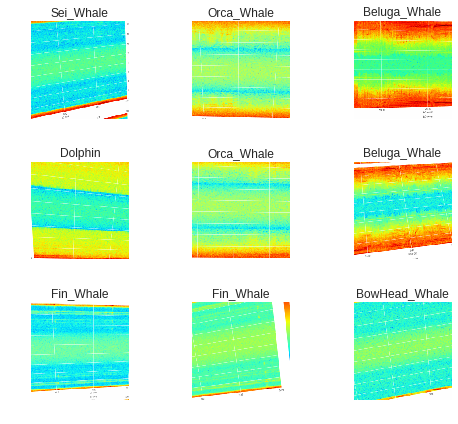

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
len(data.classes),data.c

['Beluga_Whale', 'Blue_Whale', 'BowHead_Whale', 'Dolphin', 'Fin_Whale', 'HumpBack_Whale', 'Orca_Whale', 'Sei_Whale']


(8, 8)

In [0]:
!pip install https://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-linux_x86_64.whl

# Training: resnet34
***Now we will start training our model. We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier ***

***We will train for 4 epochs (4 cycles through all our data).***

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.668835,2.188382,0.736842,00:31
1,2.333582,1.939466,0.684211,00:30
2,1.994401,1.671233,0.578947,00:31
3,1.661720,1.491111,0.473684,00:31


In [0]:
learn.save('stage-1')

# Results

***Let's see what results we have got.***

***We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly.***


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

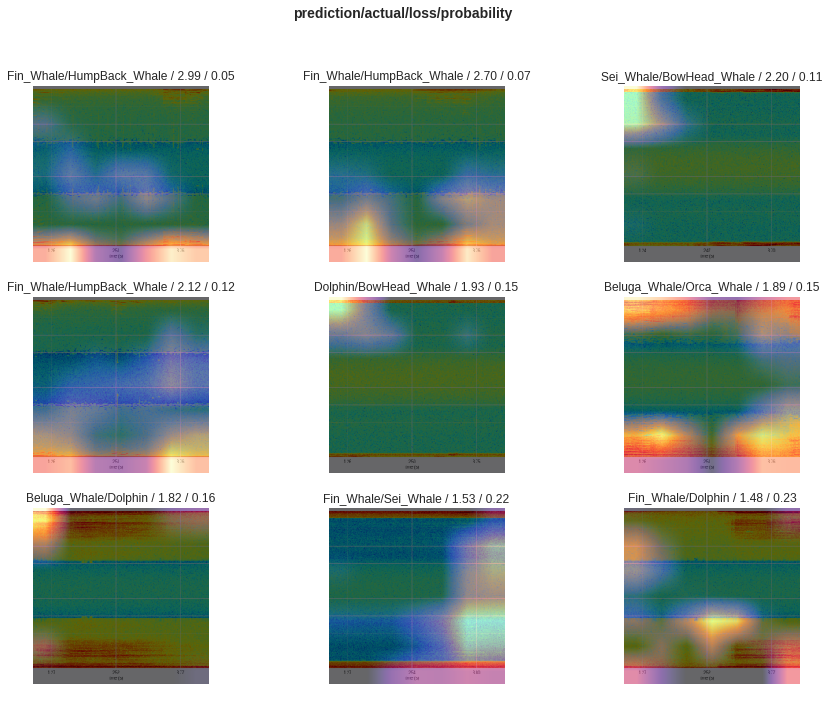

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

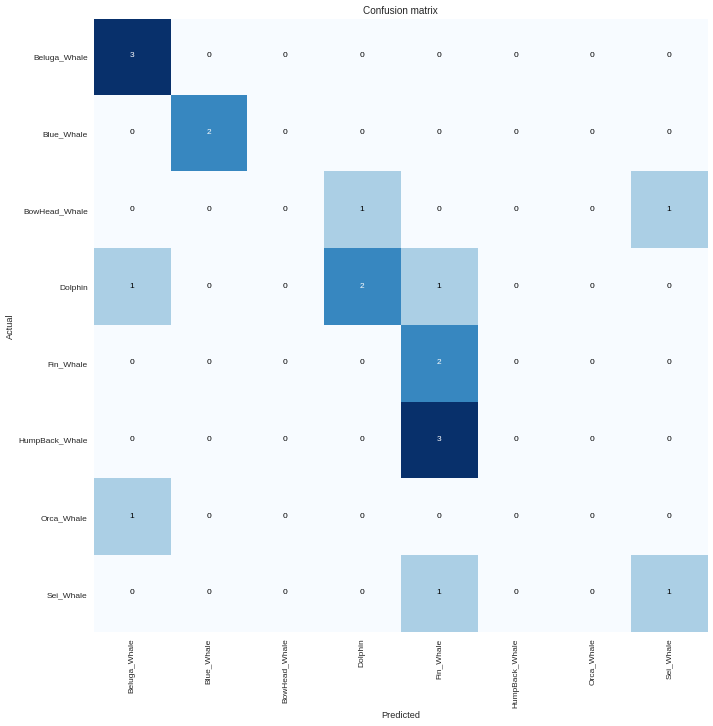

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('HumpBack_Whale', 'Fin_Whale', 3)]


# Unfreezing, fine-tuning, and learning rates

***Since our model is working as we expect it to, we will unfreeze our model and train some more.***

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.772807,1.463631,0.526316,00:41


In [0]:
learn.load('stage-1');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


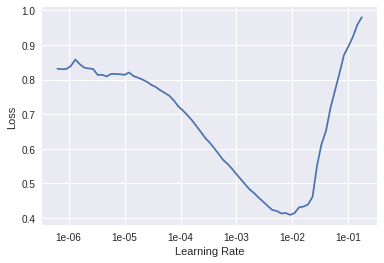

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.841121,1.275725,0.421053,00:41
1,0.854916,1.125230,0.315789,00:41


epoch,train_loss,valid_loss,error_rate,time
0,0.684968,1.352533,0.473684,00:41
1,0.739900,1.220340,0.421053,00:41


***Let's Say We Can Do Better , i Know I'm Optimistic  ***

---



---



# Training: resnet50
***Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers)***. 

***Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.***

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 85791647.83it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


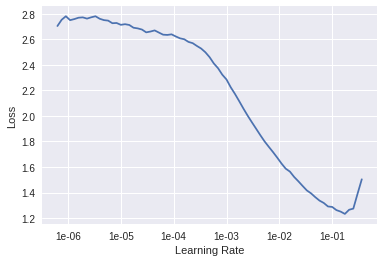

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:

learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.750884,1.839448,0.684211,01:32
1,2.083739,1.288028,0.368421,01:32
2,1.466691,0.771140,0.315789,01:32
3,1.149834,0.395076,0.105263,01:33
4,0.936229,0.174000,0.000000,01:32
5,0.776840,0.096709,0.000000,01:32
6,0.682570,0.064770,0.000000,01:32
7,0.620493,0.063760,0.000000,01:33


In [0]:
learn.save('stage-1-50')

***Who's The Boss Now !!!!***

**100% Accuracy !!!!!!**

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.181947,0.061846,0.000000,01:58
1,0.244267,0.058382,0.000000,01:56
2,0.238620,0.046672,0.000000,01:56


In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

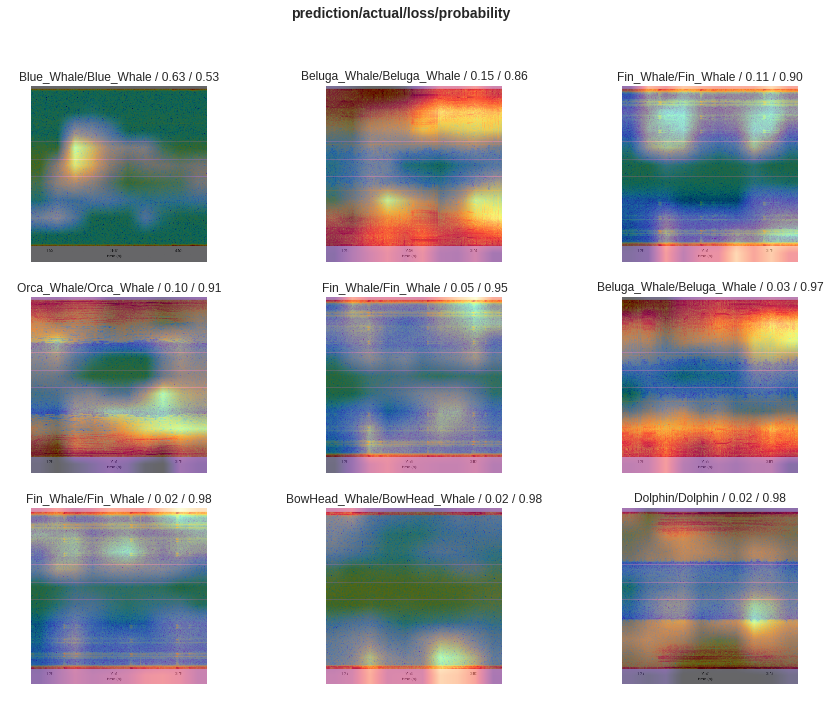

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

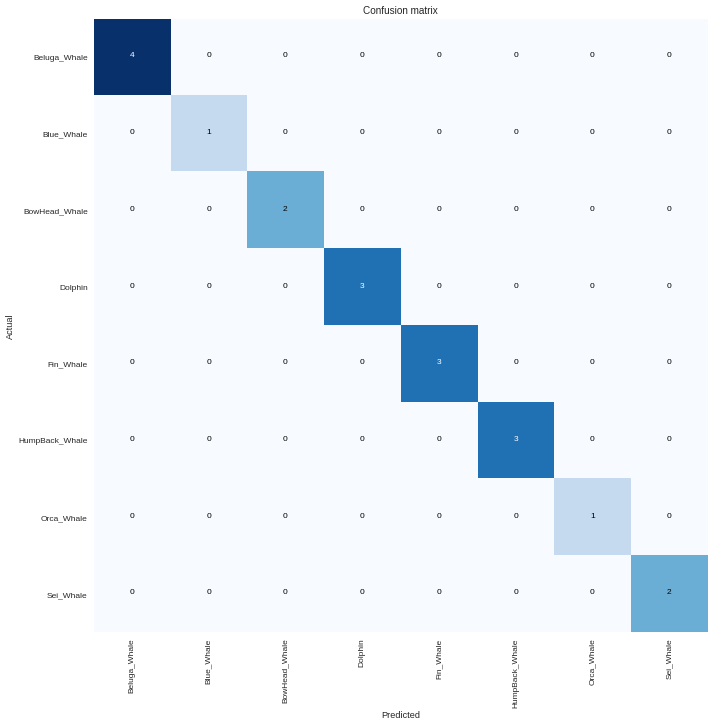

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)